### Prediction of Cost of a shipment at DB Schenker

**Introduction**


DB Schenker acts mostly as an intermediary between customers who want to ship some goods and carriers who transport the goods.
In land transport, dispatchers receive orders of shipments and find suitable carriers. This is a process that relies almost entirely on human decisions and interactions. The dispatcher has some tools to access a list of available carriers, and contacts them until he finds someone with whom he agrees on a price. When the price is agreed, the carrier takes the responsibility of delivering the given shipment from the origin to the destination.
It is easy to imagine that deciding the price for a shipment is not an easy task.

Hence it is important to build a model to predict the price that the dispatchers can use as a guideline.


**Goal of the Project**

To build an accurate model to predict the shipping costs of the transport using the land transport data obtained from January 2017 till January 2019 in China.

**Structure of the notebook**

1. Load Data and Packages
2. Exploring the data
3. Clean Data
4. Analyzing the Test Variable (Cost)
5. Feature Transformation/Engineering
6. Modeling and Predictions
7. Summary

**Importing the Libraries**

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = "{:,.2f}".format

/tmp/ipykernel_5569/146923546.py:6: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


**Loading the data**

In [2]:
df_train = pd.read_csv("data/train_data.csv", sep = ";")

**Exploring the data**

In [3]:
# reading the data set
df_train.head(10)

In [4]:
#df_train.tail()

In [44]:
#Checking for how many rows and columns
df_train.shape

(251155, 9)

In [45]:
#Checking for the column names
df_train.columns

Index(['origin_latitude', 'origin_longitude', 'destination_latitude',
       'destination_longitude', 'weight', 'loading_meters', 'is_adr',
       'shipping_date', 'cost'],
      dtype='object')

In [46]:
#Checking for null values in each column
df_train.isnull().sum()

origin_latitude          0
origin_longitude         0
destination_latitude     0
destination_longitude    0
weight                   0
loading_meters           0
is_adr                   0
shipping_date            0
cost                     0
dtype: int64

The above results shows that there are no null values.

In [47]:
# Checking for type of data present in the dataframe
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251155 entries, 0 to 251154
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   origin_latitude        251155 non-null  float64
 1   origin_longitude       251155 non-null  float64
 2   destination_latitude   251155 non-null  float64
 3   destination_longitude  251155 non-null  float64
 4   weight                 251155 non-null  float64
 5   loading_meters         251155 non-null  float64
 6   is_adr                 251155 non-null  bool   
 7   shipping_date          251155 non-null  object 
 8   cost                   251155 non-null  float64
dtypes: bool(1), float64(7), object(1)
memory usage: 15.6+ MB


The above information shows that except the variable "is_adr" (is it a dangerous good?), all other variables are in float form.

In [48]:
# Checking for unique values
df_train.nunique()

origin_latitude          776
origin_longitude         912
destination_latitude     803
destination_longitude    978
weight                   582
loading_meters           310
is_adr                     1
shipping_date            731
cost                     979
dtype: int64

In [49]:
# Finding the descriptive statistics
df_train.describe()

,origin_latitude,origin_longitude,destination_latitude,destination_longitude,weight,loading_meters,cost
count,"251,155.00","251,155.00","251,155.00","251,155.00","251,155.00","251,155.00","251,155.00"
mean,25.70,108.93,25.58,108.97,0.41,0.17,0.34
std,1.78,2.09,1.98,2.30,0.13,0.06,0.13
min,21.71,102.97,21.65,103.00,0.05,0.00,0.02
25%,24.31,107.34,23.78,107.18,0.33,0.20,0.25
50%,25.65,108.89,25.64,109.40,0.47,0.20,0.33
75%,26.91,110.46,27.17,110.75,0.49,0.20,0.41
max,30.22,114.21,30.40,114.25,1.00,0.99,2.35


The mean value of the cost is 0.34. 

In [50]:
bool_features=df_train[['is_adr']]
bool_features.describe()

,is_adr
count,251155
unique,1
top,True
freq,251155


**Changing the variable "is_adr" from Boolean values to integer**

Changing the boolean value to numeric will help for further visualization and analysis

In [51]:
df_train["is_adr"] = df_train["is_adr"].astype(int)

**Changing Time to datetime stamp**

In [9]:
df_train['shipping_date'] = pd.to_datetime(df_train['shipping_date'], format='%Y-%m-%d')

In [78]:
df_train.head(10)

**Analysing the data**

Where is the Origin of shipment (Country) takeplace?

In [6]:
# # Geographical Plot
# fig = px.scatter_mapbox(df_train, lat="origin_latitude", lon="origin_longitude", color="cost", center={'lat':23, 'lon':115},
#                         zoom=5, height=400, width=800, title="Cost in Origin place")
# # earth background
# fig.update_layout(
#     mapbox_style="open-street-map",
#     )
# fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(margin={"r":0,"t":30,"l":0,"b":50})

# fig.show()

Where is the destination of shipment (Country) takeplace?

In [5]:
# fig = px.scatter_mapbox(df_train, lat="destination_latitude", lon="destination_longitude", color="cost", center={'lat':23, 'lon':115},
#                         zoom=5, height=400, width=800, title="Cost in Delivery place")
# # earth background
# fig.update_layout(
#     mapbox_style="open-street-map",
#     )
# fig.update_layout(mapbox_style="open-street-map")
# fig.update_layout(margin={"r":0,"t":30,"l":0,"b":50})


The geographical map shows that the origin and destination of the data is obtained from China.

**Exploring the relationship between two variables using pair plots** 

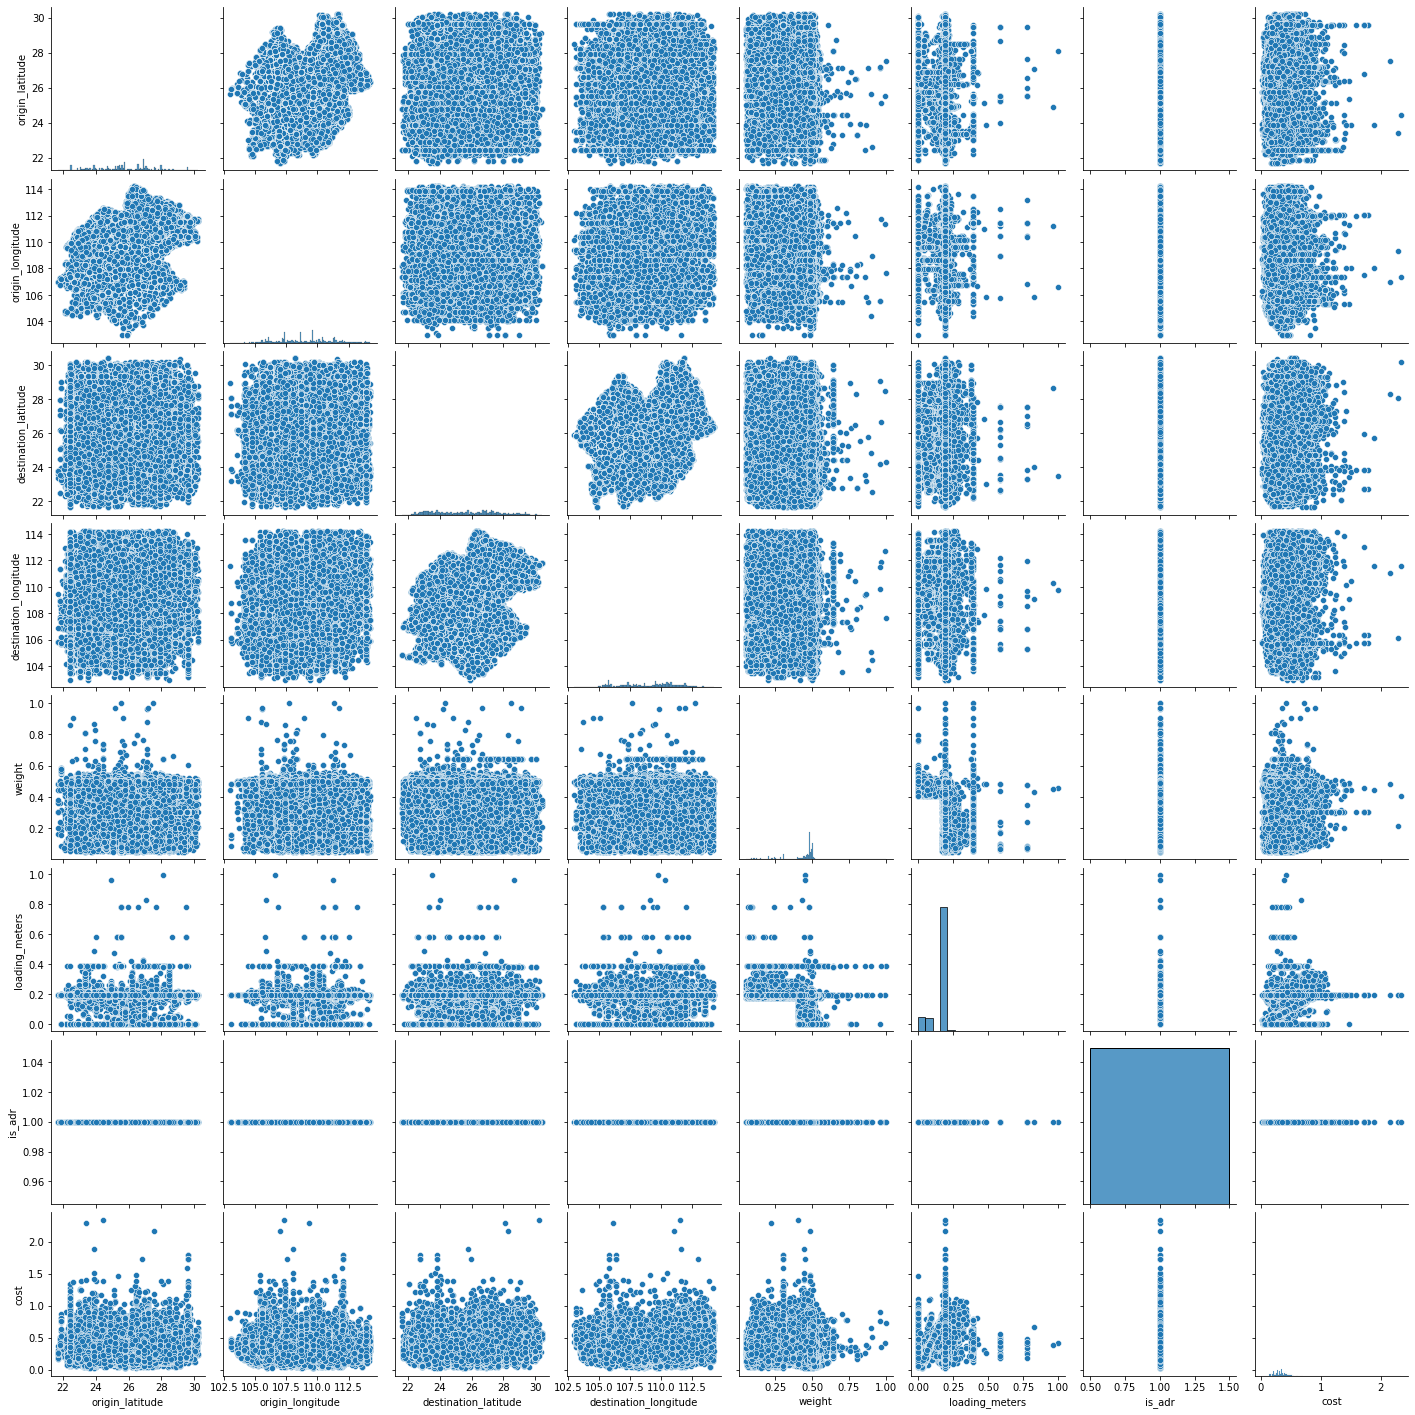

In [80]:
sns.pairplot(df_train)

The pairplot shows the variations in each plot. The plots are in matrix format where the row name represents x axis and column name represents the y axis. The main-diagonal subplots are the univariate histograms (distributions) for each attribute.

Pair plot is used to understand the best set of features to explain a relationship between two variables or the  separated clusters. It also helps to form some simple classification models by drawing some simple lines or make linear separation in our data-set.


**Correlation heat map**

Correlation heatmaps is used to find the relationships between variables and to understand the strength of these relationships. 

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train.corr(),cbar=True,annot=True,cmap='Blues')
plt.title('Correlation heat map', fontweight='bold')

**Daily Shipping Cost**

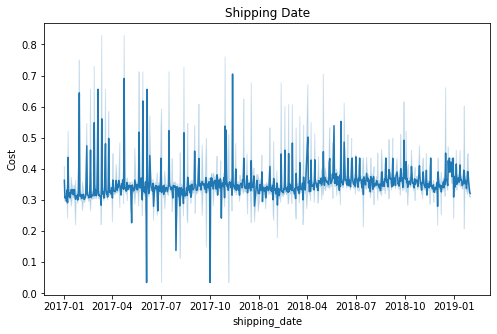

In [10]:
fig, ax = plt.subplots()
sns.lineplot(x=df_train['shipping_date'], y=df_train['cost'] , data=df_train, ax=ax)
ax.set(title='Shipping Date', ylabel=r'Cost');

From the above graph the daily shipping cost shows that most of the value falls between 0.3 and 0.35. The lowest cost was recorded in October 2017 and the highest cost recorded in March 2017.

### Distribution of Cost

/root/.pyenv/versions/3.9.4/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


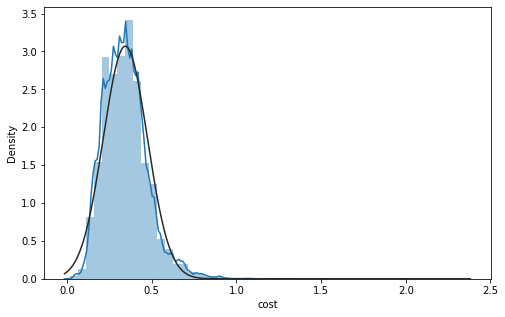

In [12]:
sns.distplot(df_train['cost'], fit=norm);

The distribution of cost curve shows that the cost variable is slightly right skewed.

**Comparing Weight and Cost**

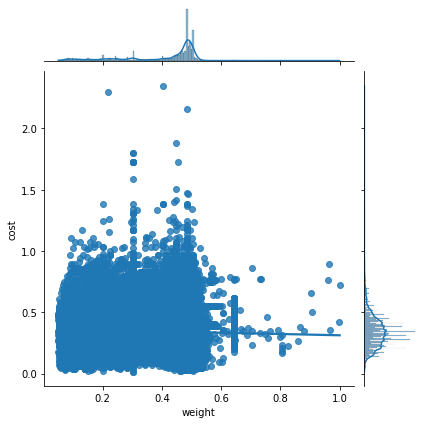

In [26]:
# Weight vs Cost
sns.jointplot(x=df_train['weight / kg'], y=df_train['cost'], kind='reg')

The plot shows that most of the shipments are between 0.05 - 0.6 kg approaximately and there is not much linearity between the weight and cost. 

**Comparing Length of the shipment to Cost**

<AxesSubplot:xlabel='loading_meters', ylabel='cost'>

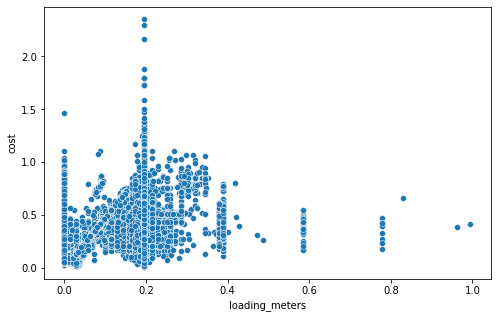

In [63]:
sns.scatterplot(data=df_train, x="loading_meters", y="cost")

The scatter plot of the distance between the length of the shipment and cost also shows that there is no linear relationship between them.

## Modelling

In [70]:
# Import linear regression from sklearn library
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

In [75]:
y = df_train['cost']
X = df_train.drop('cost', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Baseline Model